In [8]:
train_root = r'D:\I\NTU\Data\new622\train'
test_root = r'D:\I\NTU\Data\new622\test'
val_root = r'D:\I\NTU\Data\new622\val'

batch_size = 20


In [9]:
import os
import keras
import numpy as np
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, f1_score, recall_score


In [10]:
dim = (176, 208)
inputShape = (176, 208, 3)
train_Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0,
                               brightness_range=[0.8, 1.2], zoom_range=[.99, 1.01], horizontal_flip=True, vertical_flip=True)
train_data = train_Generator.flow_from_directory(train_root, target_size=dim, batch_size=batch_size)


Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0)
Generator_TTA = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0, horizontal_flip=True)

val_data = Generator.flow_from_directory(val_root, target_size=dim, batch_size=batch_size)
test_data = Generator.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)
test_data_TTA = Generator_TTA.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)


Found 6852 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.


In [11]:
num_classes = len([i for i in os.listdir(train_root)])
print(num_classes)


4


In [12]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1, mode='max', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)
callback_list = [earlyStopping, reduce]


In [13]:
model = Sequential()

resnet = ResNet50(weights=None,classes=4)
model.add(resnet)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4)                 23595908  
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
%%time
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
training = model.fit(train_data, validation_data=val_data, callbacks=callback_list,
                     batch_size=batch_size, epochs=100, shuffle=True)


Epoch 1/100
343/343 [==============================] - 79s 211ms/step - loss: 1.1385 - accuracy: 0.5028 - val_loss: 4.1149 - val_accuracy: 0.4985
Epoch 2/100
343/343 [==============================] - 68s 198ms/step - loss: 0.9384 - accuracy: 0.5375 - val_loss: 1.2290 - val_accuracy: 0.5094
Epoch 3/100
343/343 [==============================] - 65s 188ms/step - loss: 0.9229 - accuracy: 0.5476 - val_loss: 1.2192 - val_accuracy: 0.4008
Epoch 4/100
343/343 [==============================] - 61s 179ms/step - loss: 0.8902 - accuracy: 0.5663 - val_loss: 1.1730 - val_accuracy: 0.5081
Epoch 5/100
343/343 [==============================] - 61s 177ms/step - loss: 0.8800 - accuracy: 0.5734 - val_loss: 0.8444 - val_accuracy: 0.5848
Epoch 6/100
343/343 [==============================] - 61s 176ms/step - loss: 0.8753 - accuracy: 0.5749 - val_loss: 0.9834 - val_accuracy: 0.5348
Epoch 7/100
343/343 [==============================] - 61s 177ms/step - loss: 0.8525 - accuracy: 0.5912 - val_loss: 1.0419 -

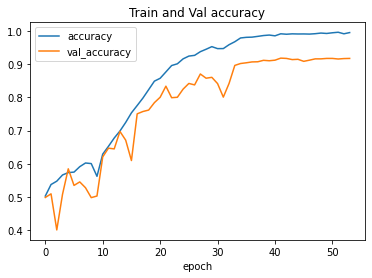

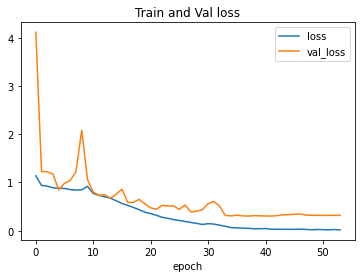

In [15]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Train and Val accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='best')
plt.show()


plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Train and Val loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.show()


In [16]:
score = model.evaluate(train_data)
print('Train Acccuray :', score[1])
score = model.evaluate(val_data)
print('Val Acccuray :', score[1])
score = model.evaluate(test_data)
print('Test Acccuray :', score[1])
score = model.evaluate(test_data_TTA)
print('Test TTA Acccuray :', score[1])

343/343 [==============================] - 53s 153ms/step - loss: 0.0148 - accuracy: 0.9971
Train Acccuray : 0.9970811605453491
115/115 [==============================] - 6s 48ms/step - loss: 0.3028 - accuracy: 0.9181
Val Acccuray : 0.9180902242660522
115/115 [==============================] - 6s 53ms/step - loss: 0.3087 - accuracy: 0.9100
Test Acccuray : 0.9100043773651123
115/115 [==============================] - 6s 48ms/step - loss: 0.3182 - accuracy: 0.9074
Test TTA Acccuray : 0.907383143901825


In [17]:
save_model(model,'Net622 res')

INFO:tensorflow:Assets written to: Net622 res\assets


d:\Anaconda\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:
pred = model.predict(test_data)
pred = np.argmax(pred, axis=1)


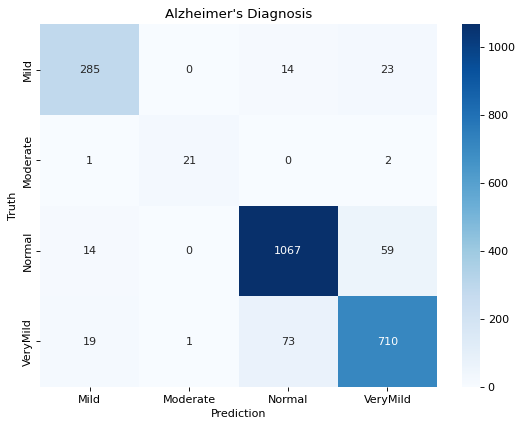

------Weighted------
Weighted precision 0.9098701004399093
Weighted recall 0.910004368719965
Weighted f1-score 0.9098892002386183
------Macro------
Macro precision 0.9166947458891492
Macro recall 0.8950605972061021
Macro f1-score 0.9054247674101707
------Micro------
Micro precision 0.910004368719965
Micro recall 0.910004368719965
Micro f1-score 0.9100043687199649


In [19]:
cm = confusion_matrix(y_true=test_data.classes, y_pred=pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

print('------Weighted------')
print('Weighted precision', precision_score(test_data.classes, pred, average='weighted'))
print('Weighted recall', recall_score(test_data.classes, pred, average='weighted'))
print('Weighted f1-score', f1_score(test_data.classes, pred, average='weighted'))
print('------Macro------')
print('Macro precision', precision_score(test_data.classes, pred, average='macro'))
print('Macro recall', recall_score(test_data.classes, pred, average='macro'))
print('Macro f1-score', f1_score(test_data.classes, pred, average='macro'))
print('------Micro------')
print('Micro precision', precision_score(test_data.classes, pred, average='micro'))
print('Micro recall', recall_score(test_data.classes, pred, average='micro'))
print('Micro f1-score', f1_score(test_data.classes, pred, average='micro'))

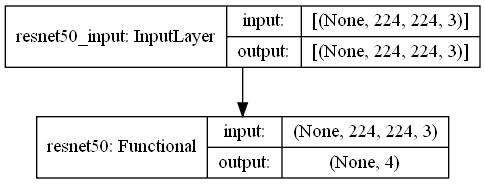

In [20]:
tf.keras.utils.plot_model(model, to_file="Net622 res.png", show_shapes=True)
